In [1]:
from tensorflow.keras.initializers import HeUniform, GlorotNormal
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.layers import LeakyReLU

In [2]:
from keras.regularizers import L2

In [3]:
import os
from itertools import combinations, product
from random import sample, shuffle, seed

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.math import reduce_sum, square, reduce_mean, maximum, sqrt
from tensorflow import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, BatchNormalization
from keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model, Sequential
from keras.applications import resnet
from keras.callbacks import TensorBoard

from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.applications import resnet


import numpy as np
import cv2
from math import ceil

In [4]:
np.random.seed(42)
random.set_seed(42)

img_h, img_w = 155, 220

In [5]:
#For BHSig
dirs_list=os.listdir("E:\Academics\Project\BHSig260-Hindi\BHSig260-Hindi")
path="E:\Academics\Project\BHSig260-Hindi\BHSig260-Hindi\\"

def get_dataset(from_dir, to_dir):
    org_sign=[]
    forg_sign=[]
    for directory in dirs_list[from_dir:to_dir]:
        images = os.listdir(path+directory)
        images.sort()
        images = [directory+'\\'+x for x in images]
        forg_sign.append(images[:30])
        org_sign.append(images[30:])

    data=[]
    for i in range(len(org_sign)):
        j=0
        for signs in list(map(list,combinations(org_sign[i],2)))[:170]:
            data.append((*signs, forg_sign[i][j%30]))
            j+=1
    del org_sign, forg_sign, images
    return data

X_train=get_dataset(0, 110)
X_valid=get_dataset(110, 135)
X_test=get_dataset(135, 160)

In [28]:
#For CEDAR
dirs_list=os.listdir("E:\\Academics\\Project\\CEDAR")
path="E:\\Academics\\Project\\CEDAR\\"
def get_dataset_cedar(from_dir, to_dir):
    org_sign=[]
    forg_sign=[]
    for directory in dirs_list[from_dir:to_dir]:
        images = os.listdir(path+directory)
        images.sort()
        images = [directory+'\\'+x for x in images]
        forg_sign.append(images[:24])
        org_sign.append(images[24:])

    data=[]
    for i in range(len(org_sign)):
        j=0
        for signs in list(map(list,combinations(org_sign[i],2)))[:170]:
            data.append((*signs, forg_sign[i][j%24]))
            j+=1
    del org_sign, forg_sign, images
    return data

X_cedar=get_dataset_cedar(0, 56)
'''X_train=get_dataset(0, 38)
X_valid=get_dataset(38, 47)
X_test=get_dataset(47, 56)'''

'X_train=get_dataset(0, 38)\nX_valid=get_dataset(38, 47)\nX_test=get_dataset(47, 56)'

In [6]:
class SignatureSequence(Sequence):
    
    def __init__(self, X, batch_size, dim):
        self.X=X
        self.dim = dim
        self.batch_size = batch_size
        

    def __len__(self):
        return ceil(len(self.X) / self.batch_size)-1

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        part_1 = np.empty((self.batch_size, *self.dim,3))
        part_2 = np.empty((self.batch_size, *self.dim,3))
        part_3 = np.empty((self.batch_size, *self.dim,3))
        
        for i in range(len(batch_X)):
            part_1[i,]=self.image_preprocessing(batch_X[i][0])
            part_2[i,]=self.image_preprocessing(batch_X[i][1])
            part_3[i,]=self.image_preprocessing(batch_X[i][2])
            batch_X_pro=(part_1 ,part_2, part_3)
        return batch_X_pro

    def image_preprocessing(self, signature):
        signature = cv2.imread(path+signature)
        resized_signature = cv2.resize(signature,(220,155))
        resized_signature=self.removebackground(resized_signature)

        gray_signature=cv2.cvtColor(resized_signature,cv2.COLOR_BGR2GRAY)
        #USE EITHER GAUSIAN BLUR OR BILATERAL FITERAL DEPENDING ON THE ACCURACY
        gray_blur = cv2.GaussianBlur(gray_signature,(5,5),0)
        #plt.imshow(gray_blur)
        #CHECK WITH 50 to 200 and 80 to 200
        edges_o= cv2.Canny(gray_blur, 80,200)
        #plt.imshow(edges_o)
        bckgnd = np.full_like(resized_signature, (255,255,255))
        #plt.imshow(bckgnd)
        contours, hierarchy = cv2.findContours(edges_o.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # draw all contours
        image23 = cv2.drawContours(resized_signature, contours, -1, (255, 0, 0), 1)
        gray_signature=cv2.cvtColor(image23, cv2.COLOR_BGR2GRAY)
        #plt.imshow(gray_signature)
        gray_signature[gray_signature==255] = 0
        bef_gray = cv2.threshold(gray_signature, 10, 255, cv2.THRESH_BINARY)[1]
        bef_gray = np.true_divide(bef_gray, 255)
        signature_expanded = bef_gray[:, :, np.newaxis]
        return np.array(signature_expanded)

        
    def removebackground(self, img):
        hh, ww = img.shape[:2]
        #plt.imshow(img)
        # threshold on white
        lower = np.array([200, 200, 200])
        upper = np.array([255, 255, 255])
        # Create mask to only select white
        thresh = cv2.inRange(img, lower, upper)
        #plt.imshow(thresh)
        thresh_inv = 255 - thresh
        #plt.imshow(thresh_inv)
        contours = cv2.findContours(thresh_inv , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
        mask = np.zeros((hh,ww), dtype=np.uint8)
        cv2.drawContours(mask, contours, -1, (255,255,255), cv2.FILLED)
        mask_inv = 255 - mask
        bckgnd = np.full_like(img, (255,255,255))
        #Add it
        image_masked = cv2.bitwise_and(img, img, mask=mask)
        bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask_inv)
        result = cv2.add(image_masked, bckgnd_masked)
        #plt.imshow(result)
        #plt.axis('off')
        #plt.show()
        return result
        
    def on_epoch_end(self):        
        np.random.shuffle(self.X)

In [7]:
input_shape=(155,220,3)
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
)

flatten = GlobalAveragePooling2D()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu", kernel_regularizer=L2(0.001))(flatten)
dense1 = Dropout(0.2)(dense1)
dense1 = layers.BatchNormalization()(dense1)

dense2 = layers.Dense(256, activation="relu", kernel_regularizer=L2(0.001))(dense1)
dense2 = Dropout(0.2)(dense2)
dense2 = layers.BatchNormalization()(dense2)

output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [8]:
from keras import backend as K

In [9]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        
        sum_square1 = tf.math.reduce_sum(tf.math.square(anchor - positive), axis=1, keepdims=True)
        ap_distance = tf.math.sqrt(tf.math.maximum(sum_square1, tf.keras.backend.epsilon()))
        
        sum_square2 = tf.math.reduce_sum(tf.math.square(anchor - negative), axis=1, keepdims=True)
        an_distance = tf.math.sqrt(tf.math.maximum(sum_square2, tf.keras.backend.epsilon()))
        
        
        '''ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)'''
        
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [10]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        square_pred = tf.math.square(an_distance)
        margin_square = tf.math.square(tf.math.maximum(self.margin - (an_distance), 0))
        loss = tf.math.reduce_mean((1 - ap_distance) * square_pred + (ap_distance) * margin_square)      
        
        '''loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)'''
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [11]:
from tensorflow.keras import metrics

In [12]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [13]:
nan_terminate=tf.keras.callbacks.TerminateOnNaN()
early_stp=EarlyStopping(patience=2, restore_best_weights=True)
checkpoint_cb=ModelCheckpoint('shallow_best_model.h5', save_best_only=True, save_weights_only=True)

In [15]:
dim=(155,220)
batch_size=64
train_batch=SignatureSequence(np.array(X_train), batch_size, dim)
valid_batch=SignatureSequence(np.array(X_valid),batch_size, dim)
history=siamese_model.fit(train_batch, validation_data=valid_batch, epochs=3, steps_per_epoch=len(X_train)//batch_size, validation_steps=len(X_valid)//batch_size, callbacks=[checkpoint_cb, nan_terminate, early_stp])

Epoch 1/3
292/292 [==============================] - 574s 2s/step - loss: 0.0115 - val_loss: 0.0023
Epoch 2/3
292/292 [==============================] - 622s 2s/step - loss: 9.8234e-04 - val_loss: 7.0455e-04
Epoch 3/3
292/292 [==============================] - 460s 2s/step - loss: 3.5458e-04 - val_loss: 4.0472e-04


In [31]:
import matplotlib.pyplot as plt

TypeError: Image data of dtype <U18 cannot be converted to float

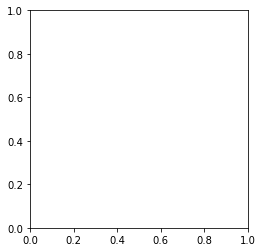

In [33]:
plt.imshow(X_cedar[0][0])

In [ ]:
dim=(155,220)
batch_size=64

In [16]:
test_batch=SignatureSequence(np.array(X_test),batch_size, dim)

In [17]:
siamese_model.evaluate(test_batch)

66/66 [==============================] - 83s 1s/step - loss: 3.4619e-04


0.00034619326470419765

In [34]:
test_batch_cedar=SignatureSequence(np.array(X_cedar),batch_size, dim)
siamese_model.evaluate(test_batch_cedar)

146/146 [==============================] - 189s 1s/step - loss: 0.0085


0.00850170198827982

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sample = test_batch[0]
#visualize(*sample)
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = euclidean_distance(anchor_embedding, positive_embedding)
#positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print(positive_similarity.numpy())

negative_similarity = euclidean_distance(anchor_embedding, negative_embedding)
#negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print(negative_similarity.numpy())

In [37]:
post=[]
neg=[]
for anchor, positive, negative in test_batch_cedar:
    anchor_embedding, positive_embedding, negative_embedding = (embedding(anchor), embedding(positive), embedding(negative))
    post.append(euclidean_distance(anchor_embedding, positive_embedding).numpy())
    neg.append(euclidean_distance(anchor_embedding, negative_embedding).numpy())

In [38]:
min(neg)

1.7086294

In [39]:
max(post)

2.6478195

In [47]:
len(post)

146

In [45]:
result=[]
for x, y in zip(post, neg):
    result.append(str(x-y)[0]=='-')

In [46]:
result.count(True)

144

In [43]:
result=[]
for x, y in zip(post, neg):
    print(x-y)

-0.5245545
-0.2448479
-0.30974054
-0.40081167
-0.7218566
-0.571563
-0.19700933
-0.2931049
-0.5290394
-0.29591918
-0.6369505
-0.47938108
-0.12155044
-0.23866963
-0.13213742
-0.6709626
-0.5317565
-0.39680123
-0.3736577
-0.23343515
-0.102808
-0.20616305
-1.099057
-0.44471264
-0.33997405
-0.15065384
-0.5965122
-0.3122338
-0.12608528
-0.2433114
-0.43985784
-0.1766833
-0.42625237
-0.47692585
-0.7765323
-0.3117261
-0.07850242
-0.54954004
-0.04096794
-0.42212105
-0.34157515
-0.4290943
-0.7402655
-0.21466184
-0.22641206
-0.43509364
-0.3375957
-0.23182678
-0.382105
-0.17357326
-0.26058948
-0.2547896
-0.560951
-0.4507947
-0.39188266
-0.44451547
-0.59934497
-0.9611094
-0.46092892
-0.2395966
-0.0375731
-0.33080912
-0.48354506
-0.6518574
-0.6371455
-0.33128762
-0.18808913
-0.41440535
-0.17103982
-0.8172698
-0.49373317
-0.47853494
-0.31290436
-0.22729015
-0.7613398
-0.52878714
-0.18178248
-0.4201889
-0.36807585
-1.2779942
-0.50094986
-0.2906494
-0.76772046
-0.0752821
-0.378366
-0.6544225
-0.54828644


In [24]:
result.count(True)

66

In [25]:
result.count(False)

0

In [ ]:
58/66

In [35]:
def euclidean_distance(x, y ):
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.reduce_sum(tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon())))

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
siamese_model.save_weights('resnet_triplet_best.h5')

In [ ]:
model.load_weights('temp.h5')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, plot_roc_curve
import matplotlib.pyplot as plt

In [ ]:
def map_arr(arr):
    return list(map(int, arr)) 
def acc_th(th=0.1, step=0.1):
    global preds
    accs={}
    for i in range(0, 40, 1):
        th+=step
        accs[th]=(accuracy_score(map_arr(np.array(y_test)[:2816]==0), map_arr(preds[:2816]<th)))
    best_th=max(accs, key=accs.get)
    fpr, tpr, thresholds=roc_curve( map_arr(np.array(y_test)[:2816]==0), map_arr(preds[:2816]<best_th))
    plt.plot(fpr)
    plt.plot(1-tpr)
    plt.show()
    return "Acc: "+str(max(accs.values())), 'Best Threshold: '+str(best_th)